In [1]:
import os
import csv
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy import signal
import cv2
from sklearn.metrics import r2_score

In [2]:
### データフォルダ・データシート作成（データフォルダが存在しない場合のみ実行）

data_folder = os.getcwd().replace(os.sep, "/") + "/Data"
datasheet = data_folder + "/datasheet.csv"
print("data_folder: " + data_folder)
print("datasheet: " + datasheet)

if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    with open(datasheet, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["INFO", "", "", "", "", "", "SOFT PARAM", "", "", "", "", "", "PATH", "", "", "RESULTS"])
        writer.writerow(["Date", "Subject", "Patern", "Additional Info", "Trial Num", "", "Depth", "Gain", "Focus", "Frequency", "Dynamic Range", "", "Gonio", "Echo", "", "RMSE", "R2", "Corrcoef"])
    print("Data folder and Datasheet were created.")
else:
    print("Data folder and Datasheet already exist.")

data_folder: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data
datasheet: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/datasheet.csv
Data folder and Datasheet already exist.


In [3]:
### Parameter

## INFO
# 実験日
date = "20221021"
# 被験者
subject = "Katagi"
# 実験パターン
pattern = 2
# 補足
additional_info = ""
# 試行No.
trial_num = 4

## SOFT PARAM
# 深度(mm)
depth = 20
# ゲイン(%)
gain = 50
# フォーカス
focus = "0_7"
# 周波数(MHz)
frequency = 7
# ダイナミックレンジ(dB)
dynamic_range = 36

# 深度によってフレームレートとトリミングする範囲が変わる
depth_param = {20 : [73, [70, 1100]], 30 : [62, [85, 1085]], 40 : [54, [200, 970]], 50 : [48, [280, 890]], 60 : [43, [325, 845]]}
# Depth:              20          30         40         50         60
# Frame Rate:         73          62         54         48         43
# Triming Range:  [70, 1100] [85, 1085] [200, 970] [280, 890] [325, 845]


current_directory = os.getcwd().replace(os.sep, "/")
print("current_directory: " + current_directory)

data_path = current_directory + "/Data/" + date + "_" + subject + "_Pattern" + str(pattern)
print("data_path: " + data_path)

current_directory: C:/Users/katagi/Desktop/Research/UltrasoundImaging
data_path: C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2


In [4]:
### Arrange Target Data Folder

# 新しい解析フォルダを作成し，その中に必要なフォルダを一通り作成する
# 同じ実験データで条件を変更して解析し直すとき用

if additional_info == "":
    new_analysis = data_path + "/Analysis1"
else:
    new_analysis = data_path + "/" + additional_info


if os.path.exists(new_analysis):
    print(new_analysis + " folder already exists.")
else:
    # EchoData フォルダ直下に新しいフォルダを作成
    processed_movie_path = data_path + "/EchoData/ProcessedMovie"
    if not os.path.exists(processed_movie_path):
        os.makedirs(processed_movie_path)
    
    # new_analysis フォルダを作成
    os.makedirs(new_analysis)
    
    # new_analysis フォルダ直下に新しいフォルダを作成
    processed_data_path = new_analysis + "/ProcessedData"
    results_path = new_analysis + "/Results"
    os.makedirs(processed_data_path)
    os.makedirs(results_path)
    
    # ProcessedData フォルダ直下に新しいフォルダを作成
    echo_processed_path = processed_data_path + "/EchoProcessed"
    gonio_processed_path = processed_data_path + "/GonioProcessed"
    os.makedirs(echo_processed_path)
    os.makedirs(gonio_processed_path)
    
    # EchoProcessed フォルダ直下に新しいフォルダを作成
    opticalflow_movie_path = echo_processed_path + "/OpticalflowMovie"
    original_fp_path = echo_processed_path + "/OriginalFP"
    processed_fp_path = echo_processed_path + "/ProcessedFP"
    echo_comparison_path = echo_processed_path + "/EchoComparison"
    os.makedirs(opticalflow_movie_path)
    os.makedirs(original_fp_path)
    os.makedirs(processed_fp_path)
    os.makedirs(echo_comparison_path)
    
    # GonioProcessed フォルダ直下に新しいフォルダを作成
    processed_theta_path = gonio_processed_path + "/ProcessedTheta"
    gonio_comparison_path = gonio_processed_path + "/GonioComparison"
    os.makedirs(processed_theta_path)
    os.makedirs(gonio_comparison_path)
    
    # Results フォルダ直下に新しいフォルダ・結果用csvファイルを作成
    point_behavior_path = results_path + "/PointBehavior"
    angle_estimation_path = results_path + "/AngleEstimation"
    RMSE_R2_coef = results_path + "/RMSE_R2_coef.csv"
    os.makedirs(point_behavior_path)
    os.makedirs(angle_estimation_path)
    # 各解析ごとの結果用csvファイル作成
    with open(RMSE_R2_coef, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["INFO", "", "", "", "", "", "SOFT PARAM", "", "", "", "", "", "PATH", "", "", "RESULTS"])
        writer.writerow(["Date", "Subject", "Patern", "Additional Info", "Trial Num", "", "Depth", "Gain", "Focus", "Frequency", "Dynamic Range", "", "Gonio", "Echo", "", "RMSE", "R2", "Corrcoef"])

    print(processed_movie_path + " folder was successfully created.")
    print(new_analysis + " folder was successfully created.")
    print(processed_data_path + " folder was successfully created.")
    print(results_path + " folder was successfully created.")
    print(echo_processed_path + " folder was successfully created.")
    print(gonio_processed_path + " folder was successfully created.")
    print(opticalflow_movie_path + " folder was successfully created.")
    print(original_fp_path + " folder was successfully created.")
    print(processed_fp_path + " folder was successfully created.")
    print(echo_comparison_path + " folder was successfully created.")
    print(processed_theta_path + " folder was successfully created.")
    print(gonio_comparison_path + " folder was successfully created.")
    print(point_behavior_path + " folder was successfully created.")
    print(angle_estimation_path + " folder was successfully created.")

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1 folder already exists.


In [5]:
### データを一つ取り出し出力

if additional_info == "":
    analysis_path = data_path + "/Analysis1"
else:
    analysis_path = data_path + "/" + additional_info
    

# ゴニオデータファイルをリストで取得
gonio_path = data_path + "/GonioData"
gonio_files = list()
for file in os.listdir(gonio_path):
    if file.endswith(".csv"):
        gonio_files.append(file)

# エコーデータファイルをリストで取得
echo_path = data_path + "/EchoData"
echo_files = list()
for file in os.listdir(echo_path):
    if file.endswith(".mp4"):
        echo_files.append(file)

print(gonio_files)
print(echo_files)


## PATH
# データを一つだけ取り出す
gonio_file = gonio_files[trial_num]
echo_file = echo_files[trial_num]

print("GonioData: " + gonio_file)
print("EchoData: " + echo_file)

['202210211613.csv', '202210211616.csv', '202210211619.csv', '202210211622.csv', '202210211626.csv']
['20221021 161310.mp4', '20221021 161620.mp4', '20221021 161915.mp4', '20221021 162244.mp4', '20221021 162613.mp4']
GonioData: 202210211626.csv
EchoData: 20221021 162613.mp4


In [6]:
##### ゴニオデータの処理 ####

In [7]:
### Parameter ###


gonio_frame_rate = 100
echo_frame_rate = depth_param[depth][0]
print("echo_frame_rate: " + str(echo_frame_rate))
total_time = 44
numOfData = echo_frame_rate * total_time
interpolate_rate = gonio_frame_rate * echo_frame_rate

# csvファイル内の目的データの開始位置
cut_time = 12
start_row = gonio_frame_rate * cut_time
end_row = start_row + gonio_frame_rate * total_time
target_column = 1

# ローパスフィルタ パラメータ
fp = 1.5 # 通過域端周波数[Hz] #フーリエ変換にあわせて調整
fs = 7.5 # 阻止域端周波数[Hz] # fp*5くらい
gpass = 3 # 通過域端最大損失[dB]
gstop = 40 # 阻止域端最小損失[dB]

time = np.linspace(0, total_time, numOfData) # (3212,)

print("numOfData: " + str(numOfData))
print("interpolate_rate: " + str(interpolate_rate))
print("start_row: " + str(start_row))
print("end_row: " + str(end_row))
print("time: ")
print(time, time.shape)

#################

echo_frame_rate: 73
numOfData: 3212
interpolate_rate: 7300
start_row: 1200
end_row: 5600
time: 
[0.00000000e+00 1.37028963e-02 2.74057926e-02 ... 4.39725942e+01
 4.39862971e+01 4.40000000e+01] (3212,)


In [8]:
### データ読み込み

print("GonioData: " + gonio_file)
target_gonio_path = gonio_path + "/" + gonio_file
with open(target_gonio_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    theta = list()
    for i, row in enumerate(reader):
        if i < start_row:
            continue
        if i >= end_row:
            break
        theta.append(row[target_column])
    f.close()

theta = np.array(theta).astype(float)[:]
print(theta, theta.shape)

GonioData: 202210211626.csv
[-0.8129883 -0.1263428 -1.142578  ...  1.686401   2.592773   1.164551 ] (4400,)


In [9]:
### フレームレート調整

# gonioとechoのフレームレートを合わせる
# gonioデータを補完(interpolate)しechoデータにあわせてリサンプリングする
# https://watlab-blog.com/2019/09/19/resampling/

t0 = 0    # 初期時間[s]
dt = 1/gonio_frame_rate  # 時間刻み[s] 1/100
t = np.arange(t0, total_time, dt) # (4400,)

interpolate_num = interpolate_rate * total_time # 7300 * 44 = 321200
t_interpolate = np.linspace(t0, total_time - dt, interpolate_num)


# 補間
f = interpolate.interp1d(t, theta, kind="cubic")
interpolated_theta = f(t_interpolate) # (321200,)

# リサンプリング
resampled_theta = list()
for i in range(len(interpolated_theta)):
    if i % gonio_frame_rate == 0: # 231200 / 100 = 3212(=73*44)コ
        resampled_theta.append(interpolated_theta[i])
    if (len(resampled_theta)) >= numOfData:
        break

resampled_theta = np.array(resampled_theta).astype(float)[:] # (3212,)
print("t0: " + str(t0))
print("dt: " + str(dt))
print("t: " + str(t) + str(t.shape) + "\n")
print("interpolate_num: " + str(interpolate_num) + "\n")
print("t_interpolate: ")
print(t_interpolate, t_interpolate.shape)
print("\n")
print("interpolated_theta: ")
print(interpolated_theta, interpolated_theta.shape)
print("\n")
print("resampled_theta: ")
print(resampled_theta, resampled_theta.shape)

t0: 0
dt: 0.01
t: [0.000e+00 1.000e-02 2.000e-02 ... 4.397e+01 4.398e+01 4.399e+01](4400,)

interpolate_num: 321200

t_interpolate: 
[0.00000000e+00 1.36955595e-04 2.73911189e-04 ... 4.39897261e+01
 4.39898630e+01 4.39900000e+01] (321200,)


interpolated_theta: 
[-0.8129883  -0.76630093 -0.72099957 ...  1.27904013  1.22248205
  1.164551  ] (321200,)


resampled_theta: 
[-0.8129883  -0.61013795 -0.52440972 ...  1.77626752  1.87508839
  2.27598351] (3212,)


In [10]:
### 正規化

# NumPyで配列の正規化(normalize)、標準化する方法
# https://deepage.net/features/numpy-normalize.html

theta_mean = theta.mean(axis=None, keepdims=True)
theta_std = np.std(theta, axis=None, keepdims=True)

theta_zscore = (theta - theta_mean) / theta_std


print("theta_mean: " + str(theta_mean))
print("theta_std: " + str(theta_std))
print("theta_zscore: ")
print(theta_zscore, theta_zscore.shape)

theta_mean: [-19.60922864]
theta_std: [17.72712926]
theta_zscore: 
[1.06030932 1.09904348 1.04171693 ... 1.20130165 1.25243074 1.17186372] (4400,)


正規化なし
(3212,)


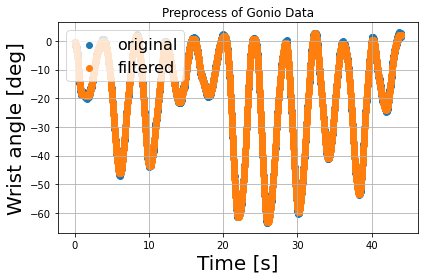

fn: 50.0
wp: 0.03
ws: 0.15
N: 3
Wn: 0.03002371892387966
b: [9.56622667e-05 2.86986800e-04 2.86986800e-04 9.56622667e-05]
a: [ 1.         -2.81142481  2.64021284 -0.82802273]
theta_low: 
[-0.23395351 -0.3104139  -0.3935583  ...  2.20259288  2.20666913
  2.21000063] (3212,)


In [11]:
### ローパスフィルタ

# 角度情報の加工
#Pythonによるデータ処理4 ～ フィルタ処理
#https://atatat.hatenablog.com/entry/data_proc_python4
#PythonのSciPyでローパスフィルタをかける！
#https://watlab-blog.com/2019/04/30/scipy-lowpass/

# 正規化しない
theta = resampled_theta
print("正規化なし")
print(theta.shape)
# # 正規化する
# theta = theta_zscore
# print("正規化")
# print(theta.shape)

fn = gonio_frame_rate / 2   #ナイキスト周波数
wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
theta_low = signal.filtfilt(b, a, theta)                  #信号に対してフィルタをかける

# 図で確認
x = time
y1 = theta
y2 = theta_low

fig = plt.figure()
plt.title("Preprocess of Gonio Data")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

print("fn: " + str(fn))
print("wp: " + str(wp))
print("ws: " + str(ws))
print("N: " + str(N))
print("Wn: " + str(Wn))
print("b: " + str(b))
print("a: " + str(a))
print("theta_low: ")
print(theta_low, theta_low.shape)


In [13]:
### 処理データ・図の保存

gonio_processed_path = analysis_path + "/ProcessedData/GonioProcessed"
processed_theta_path = gonio_processed_path + "/ProcessedTheta/" + gonio_file
gonio_comparison_path = gonio_processed_path + "/GonioComparison/" + gonio_file.split(".")[0] + ".png"
print(processed_theta_path)
print(gonio_comparison_path)


theta = theta_low
print("theta: ")
print(theta, theta.shape)
print("time: ")
print(time, time.shape)

# 前処理したゴニオデータを保存
with open(processed_theta_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Time", "Gonio"])
    for i in range(theta.shape[0]):
        writer.writerow([time[i], theta[i]])
    f.close()
    
# フィルターをかける前後のデータの比較グラフを保存
fig.savefig(gonio_comparison_path)


C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/GonioProcessed/ProcessedTheta/202210211626.csv
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/GonioProcessed/GonioComparison/202210211626.png
theta: 
[-0.23395351 -0.3104139  -0.3935583  ...  2.20259288  2.20666913
  2.21000063] (3212,)
time: 
[0.00000000e+00 1.37028963e-02 2.74057926e-02 ... 4.39725942e+01
 4.39862971e+01 4.40000000e+01] (3212,)


In [14]:
#### エコーデータの処理

In [15]:
### Parameter ###

# 計測時間(s)
start_time = 12
end_time = 56

# トリミング（元動画の超音波画像の部分のみに切り取る）
# 元動画サイズ：(1172, 608)
top, bottom = 40, 600
left, right = depth_param[depth][1][0], depth_param[depth][1][1]
# # トリミング後サイズ：(right - left, 560)
print("left, right: " + str(left) + ", " + str(right))


# 見切れ対策（最初の特徴点をトリミングした範囲内から抽出）(w:510, h:560)
trim_w = 80
trim_h = 60

# 特徴点数
feature_num = 50

####     オプティカルフローパラメータ     ####
maxCorners=500       # 特徴点の最大数
qualityLevel=0.2     # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
minDistance=25       # 特徴点間の最小距離
blockSize=15         # 特徴点の計算に使うブロック（周辺領域）サイズ

# フレーム内へ角度情報を挿入する位置
wrist_angle_position = (40, 530)

#################

left, right: 70, 1100


In [16]:
# データ読み込み

target_echo_path = echo_path + "/" + echo_file
print(target_echo_path)
print("EchoData: " + echo_file)

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/EchoData/20221021 162613.mp4
EchoData: 20221021 162613.mp4


In [17]:
### 動画の前処理（実験データごとに最初の1回だけ実行する）
# 1. 動画時間を計測時間に合わせる（必要なフレーム数だけを保存）
# 2. 画像内の不要な部分を削る(スクリーン中のエコー部分のみ)


processed_movie_path = echo_path + "/ProcessedMovie/" + echo_file

# processed_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(processed_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(target_echo_path)

    # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # フレームレート確認
    print("--Before Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    # 必要なフレームのみ取り出す
    start_frame = start_time * frame_rate # 876
    end_frame = end_time * frame_rate # 4088

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    new_size = (right - left, bottom - top)
    save = cv2.VideoWriter(processed_movie_path, fmt, frame_rate, new_size)

    for i in range(end_frame):    # 1.の処理
        ret, frame = video.read()
        if ret == False:
            break
        if i < start_frame:
            continue

        frame = frame[top:bottom, left:right]   # 2.の処理
        frame = cv2.resize(frame, new_size)
        cv2.imshow("check frame", frame)
        key = cv2.waitKey(10)
        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
        save.write(frame)

    save.release()
    video.release()
    cv2.destroyAllWindows()

    processed_video = cv2.VideoCapture(processed_movie_path)
    # 動画情報
    width = int(processed_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(processed_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(processed_video.get(cv2.CAP_PROP_FPS))   # 73, 62, 54, 48, or 43
    frame_count = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_video.release()
    print("--After Processing--")
    print("WIDTH: " + str(width) + ", HEIGHT: " + str(height))
    print("FRAME RATE: " + str(frame_rate) + ",\nFRAME COUNT: " + str(frame_count) + "\n")

    print("Preprocessing is done")
else:
    print("Processed Movie already Exists")

--Before Processing--
WIDTH: 1172, HEIGHT: 608
FRAME RATE: 73,
FRAME COUNT: 4745

--After Processing--
WIDTH: 1030, HEIGHT: 560
FRAME RATE: 73,
FRAME COUNT: 3212

Preprocessing is done


In [18]:
### オプティカルフロー（解析ごとに最初の1回だけ実行する）

processed_movie_path = echo_path + "/ProcessedMovie/" + echo_file
opticalflow_movie_path = analysis_path + "/ProcessedData/EchoProcessed/OpticalflowMovie/" + echo_file
print("processed_movie_path: ")
print(processed_movie_path)
print("opticalflow_movie_path: ")
print(opticalflow_movie_path)

# opticalflow_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_path):
    
    # 動画取得
    video = cv2.VideoCapture(processed_movie_path)

    # Shi-Tomasi法のパラメータ（コーナー：物体の角を特徴点として検出）
    ft_params = dict(maxCorners=maxCorners,       # 特徴点の最大数
    qualityLevel=qualityLevel,    # 特徴点を選択するしきい値で、高いほど特徴点は厳選されて減る。
    minDistance=minDistance,       # 特徴点間の最小距離
    blockSize=blockSize)         # 特徴点の計算に使うブロック（周辺領域）サイズ

    # Lucal-Kanade法のパラメータ（追跡用）
    lk_params = dict(winSize=(80,80),     # オプティカルフローの推定の計算に使う周辺領域サイズ
    maxLevel=4,          # ピラミッド数
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))       # 探索アルゴリズムの終了条件

    # # 動画情報
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS)) # 73, 62, 54, 48, or 43
    size = (width, height)  # (right - left, 560)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # 3212
    print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

    # 最初のフレームを取得してグレースケール変換
    ret, frame = video.read()
    frame_pre = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 最初のフレームのみさらにトリミング
    frame_pre_first = frame_pre[trim_h : height - trim_h, trim_w : width - trim_w]

    # Shi-Tomasi法で特徴点の検出
    feature_pre = cv2.goodFeaturesToTrack(frame_pre_first, mask=None, **ft_params)

    # 座標をトリミング前のものに修正
    for v in feature_pre:
        v[0][0] += trim_w
        v[0][1] += trim_h

    # mask用の配列を生成
    mask = np.zeros_like(frame)

    frame_num = 0
    # 動画終了まで繰り返し
    while(video.isOpened() and frame_num < frame_count):

        # 次のフレームを取得し、グレースケールに変換
        ret, frame = video.read()
        if ret == False:
            break

        frame_now = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Lucas-Kanade法でフレーム間の特徴点のオプティカルフローを計算
        feature_now, status, err = cv2.calcOpticalFlowPyrLK(frame_pre, frame_now, feature_pre, None, **lk_params)

        # オプティカルフローを検出した特徴点を取得
        good1 = feature_pre[status == 1] # 1フレーム目
        good2 = feature_now[status == 1] # 2フレーム目

        # 座標を保存する配列を初期化、初期位置を保存
        if frame_num == 0:
            feature_points_of_all = np.empty([0, good1.shape[0], 2])
            feature_points_of_t = good1.reshape([1, good1.shape[0], 2])
            feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

            first_num = good1.shape[0]
            print("Num of feature point at first: " + str(first_num))

        # statusが0となるインデックスを取得
        vanish = np.where(status == 0)[0]

        # position_allからstatus=0の要素を削除
        for i, v in enumerate(vanish):
            # 最初のフレーム間で特徴点が消えている場合は何もしない
            if frame_num == 0:
                break
            feature_points_of_all = np.delete(feature_points_of_all, v - i, 1)

        # 各時刻における座標を保存
        feature_points_of_t = good2.reshape([1, good2.shape[0], 2])
        feature_points_of_all = np.append(feature_points_of_all, feature_points_of_t, axis=0)

        # 特徴点とオプティカルフローをフレーム・マスクに描画
        for i, (pt1, pt2) in enumerate(zip(good1, good2)):
            x1, y1 = pt1.ravel() # 1フレーム目の特徴点座標
            x2, y2 = pt2.ravel() # 2フレーム目の特徴点座標

            # 軌跡を描画（過去の軌跡も残すためにmaskに描く）
            mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)

            # 現フレームにオプティカルフローを描画
            frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

        # フレームとマスクの論理積（合成）
        img = cv2.add(frame, mask)

        # ウィンドウに表示
        cv2.imshow('mask', img)

        # 次のフレーム、ポイントの準備
        frame_pre = frame_now.copy() # 次のフレームを最初のフレームに設定
        feature_pre = good2.reshape(-1, 1, 2) # 次の点を最初の点に設定

        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        frame_num += 1

    last_num = good2.shape[0]
    print("Num of feature point at last: " + str(last_num) + "\n\n")

    # 終了処理
    cv2.destroyAllWindows()
    video.release()

    print("feature_points_of_all: ")
    print(feature_points_of_all, feature_points_of_all.shape)

else:
    print("Opticalflow Movie already exists.")

processed_movie_path: 
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/EchoData/ProcessedMovie/20221021 162613.mp4
opticalflow_movie_path: 
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/EchoProcessed/OpticalflowMovie/20221021 162613.mp4
FRAME COUNT: 3212,
WIDTH: 1030, HEIGHT: 560

Num of feature point at first: 140
Num of feature point at last: 140


feature_points_of_all: 
[[[225.         363.        ]
  [779.          64.        ]
  [441.         427.        ]
  ...
  [174.         217.        ]
  [809.         120.        ]
  [481.          69.        ]]

 [[224.77766418 363.16287231]
  [779.02172852  64.00234985]
  [441.28448486 427.01675415]
  ...
  [173.59747314 217.1282196 ]
  [809.02496338 120.0085144 ]
  [481.04699707  69.00869751]]

 [[224.63311768 363.22735596]
  [779.03070068  63.97889709]
  [441.8097229  426.96609497]
  ...
  [173.75857544 217.3707428 ]
  [808.96252441 119.91001129]

In [19]:
### 特徴点の選出・csvファイルへの保存（解析ごとに最初の1回だけ実行する）

original_fp_path = analysis_path + "/ProcessedData/EchoProcessed/OriginalFP/" + echo_file.split(".")[0] + ".csv"
print(original_fp_path)

# original_fp_pathが存在しない場合のみこのセルを実行
if not os.path.exists(original_fp_path):
    
    # 特徴点を選出
    feature_points_data = np.delete(feature_points_of_all, np.s_[feature_num:], 1) # (3212, 50, 2)
    feature_points_data = feature_points_data.reshape(
        [feature_points_data.shape[0], feature_points_data.shape[1] * 2]) # (3212, 100)
    print("feature_points_data: ")
    print(feature_points_data, feature_points_data.shape)

    # 特徴点データを保存
    with open(original_fp_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Feature Points Data"])
        for each_time_data in feature_points_data:
            writer.writerow(each_time_data)
        f.close()
    print("Save completed")

else:
    print("Original FP already exists.")

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/EchoProcessed/OriginalFP/20221021 162613.csv
feature_points_data: 
[[225.         363.         779.         ...  94.         638.
  111.        ]
 [224.77766418 363.16287231 779.02172852 ...  93.98049927 638.0111084
  111.01670837]
 [224.63311768 363.22735596 779.03070068 ...  93.99206543 637.9284668
  111.00374603]
 ...
 [265.55297852 337.63012695 782.21411133 ...  98.62451935 631.16711426
  101.04792786]
 [265.44488525 337.3744812  782.26873779 ...  98.74914551 631.27246094
  101.02399445]
 [265.12005615 337.28283691 782.29620361 ...  98.84729004 631.46203613
  101.01927185]] (3212, 100)
Save completed


In [20]:
### 特徴点データとゴニオデータの読み込み


print("EchoData: " + echo_file)
print("GonioData: " + gonio_file)

with open(original_fp_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    feature_points = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        feature_points.append(row)
    f.close()
with open(processed_theta_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    theta = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        theta.append(row[1])
    f.close()

feature_points = np.array(feature_points).astype(float)[:, :]
theta = np.array(theta).astype(float)[:]

print("feature_points: ")
print(feature_points, feature_points.shape)
print("theta: ")
print(theta, theta.shape)

EchoData: 20221021 162613.mp4
GonioData: 202210211626.csv
feature_points: 
[[225.         363.         779.         ...  94.         638.
  111.        ]
 [224.77766418 363.16287231 779.02172852 ...  93.98049927 638.0111084
  111.01670837]
 [224.63311768 363.22735596 779.03070068 ...  93.99206543 637.9284668
  111.00374603]
 ...
 [265.55297852 337.63012695 782.21411133 ...  98.62451935 631.16711426
  101.04792786]
 [265.44488525 337.3744812  782.26873779 ...  98.74914551 631.27246094
  101.02399445]
 [265.12005615 337.28283691 782.29620361 ...  98.84729004 631.46203613
  101.01927185]] (3212, 100)
theta: 
[-0.23395351 -0.3104139  -0.3935583  ...  2.20259288  2.20666913
  2.21000063] (3212,)


In [21]:
### 選出した特徴点の描画・動画保存（解析ごとに最初の1回だけ実行する）

processed_movie_path = echo_path + "/ProcessedMovie/" + echo_file
opticalflow_movie_path = analysis_path + "/ProcessedData/EchoProcessed/OpticalflowMovie/" + echo_file

# opticalflow_movie_pathが存在しない場合のみこのセルを実行
if not os.path.exists(opticalflow_movie_path):
    
    # 特徴点データを元の形に直す（1つの特徴点につきx,y座長の2データを持つ）
    feature_points = feature_points.reshape([feature_points.shape[0], feature_num, 2]) # (3212, 50, 2)
    print("feature_points: ")
    print(feature_points, feature_points.shape)

    # 動画取得
    video = cv2.VideoCapture(processed_movie_path)

    # 動画情報
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    size = (width, height)  # (right - left, 560)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))
    print("FRAME COUNT: " + str(frame_count) + ",\nWIDTH: " + str(width) + ", HEIGHT: " + str(height) + "\n")

    # 保存の準備
    fmt = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    save = cv2.VideoWriter(opticalflow_movie_path, fmt, frame_rate, size)

    # 最初のフレームを取得
    ret, frame = video.read()

    # mask用の配列を生成
    mask = np.zeros_like(frame)

    # 最初の特徴点の座標を取得
    points_pre = feature_points[0] # (50, 2)

    # 動画終了まで繰り返し
    for t in range(feature_points.shape[0] - 1):

        # 現在のフレームを取得
        ret, frame = video.read()
        if ret == False:
            print("false t: " + str(t))
            break

        # 現在の特徴点の座標を取得
        points_now = feature_points[t+1]

        # 現在の関節角度を取得
        theta_now = round(theta[t], 2)

        # オプティカルフローと現在の特徴点をmask, frameに描画
        for p_pre, p_now in zip(points_pre, points_now):
            x1, y1 = p_pre[0], p_pre[1]
            x2, y2 = p_now[0], p_now[1]

            mask = cv2.line(mask, (int(x1), int(y1)), (int(x2), int(y2)), [128, 128, 128], 1)
            frame = cv2.circle(frame, (int(x2), int(y2)), 5, [0, 0, 200], -1)

            # 関節角度情報を描画
            angle = "Wrist Angle: " + str(theta_now)
            # org = (20, 460) # 挿入する座標
            cv2.putText(frame, angle, wrist_angle_position, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5, color=(255, 255, 255))

        # frameとmaskの合成
        img = cv2.add(frame, mask)

        # ウィンドウに表示
        cv2.imshow("mask", img)

        # フレームごとに保存
        save.write(img)

        # 特徴点の更新
        points_pre = points_now

        # qキーが押されたら途中終了
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    # 終了処理
    cv2.destroyAllWindows()
    video.release()
    save.release()

    print("Save completed")
    
    # 特徴点データを解析用の形に戻す
    feature_points = feature_points.reshape([feature_points.shape[0], feature_num * 2]) # (3212, 100)

else:
    print("Opticalflow Mivie already exists.")

feature_points: 
[[[225.         363.        ]
  [779.          64.        ]
  [441.         427.        ]
  ...
  [545.         335.        ]
  [535.          94.        ]
  [638.         111.        ]]

 [[224.77766418 363.16287231]
  [779.02172852  64.00234985]
  [441.28448486 427.01675415]
  ...
  [545.03167725 334.98825073]
  [534.95141602  93.98049927]
  [638.0111084  111.01670837]]

 [[224.63311768 363.22735596]
  [779.03070068  63.97889709]
  [441.8097229  426.96609497]
  ...
  [545.20343018 334.88546753]
  [534.97119141  93.99206543]
  [637.9284668  111.00374603]]

 ...

 [[265.55297852 337.63012695]
  [782.21411133  63.9760437 ]
  [452.77362061 432.96212769]
  ...
  [600.16955566 351.92037964]
  [516.72766113  98.62451935]
  [631.16711426 101.04792786]]

 [[265.44488525 337.3744812 ]
  [782.26873779  63.98465729]
  [453.09030151 432.69665527]
  ...
  [600.63116455 351.82757568]
  [516.98852539  98.74914551]
  [631.27246094 101.02399445]]

 [[265.12005615 337.28283691]
  [782.

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/EchoProcessed/OriginalFP/20221021 162613.csv
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/EchoProcessed/ProcessedFP/20221021 162613.csv
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/EchoProcessed/EchoComparison/20221021 162613.png
EchoData: 20221021 162613.mp4

--Before Processing--
feature_points: 
[[225.         363.         779.         ...  94.         638.
  111.        ]
 [224.77766418 363.16287231 779.02172852 ...  93.98049927 638.0111084
  111.01670837]
 [224.63311768 363.22735596 779.03070068 ...  93.99206543 637.9284668
  111.00374603]
 ...
 [265.55297852 337.63012695 782.21411133 ...  98.62451935 631.16711426
  101.04792786]
 [265.44488525 337.3744812  782.26873779 ...  98.74914551 631.27246094
  101.02399445]
 [265.12005615 337.28283691 782.29620361 ... 

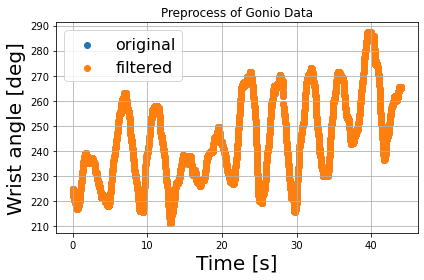

Save completed


In [22]:
### 特徴点データの処理・保存
echo_processed_path = analysis_path + "/ProcessedData/EchoProcessed"
processed_fp_path = echo_processed_path + "/ProcessedFP/" + echo_file.split(".")[0] + ".csv"
echo_comparison_path = echo_processed_path + "/EchoComparison/" + echo_file.split(".")[0] + ".png"

print(original_fp_path)
print(processed_fp_path)
print(echo_comparison_path)

print("EchoData: " + echo_file)

print("\n--Before Processing--")
print("feature_points: ")
print(feature_points, feature_points.shape)


# 正規化

processed_feature_points = feature_points


# ローパスフィルタ



# 特徴点データを保存
with open(processed_fp_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Processed Feature Points Data"])
    for each_time_data in processed_feature_points:
        writer.writerow(each_time_data)
    f.close()
    

print("\n--After Processing--")
print("processed_feature_points: ")
print(processed_feature_points, processed_feature_points.shape)


# 比較グラフの表示・保存（１つ目の特徴点のみ）
x = time
y1 = feature_points[:, 0]
y2 = processed_feature_points[:, 0]
print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig = plt.figure()
plt.title("Preprocess of Gonio Data")
plt.scatter(x, y1, label='original')
plt.scatter(x, y2, label='filtered')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(echo_comparison_path)

print("Save completed")


In [23]:
#### 解析


In [24]:
### パラメータ

# グラフ
min_height = -80
max_height = 30

# 正則化パラメータ
# lam = 0.1
lam = 0.5

In [25]:
### データ読み込み

processed_fp_path = analysis_path + "/ProcessedData/EchoProcessed/ProcessedFP/" + echo_file.split(".")[0] + ".csv"
processed_theta_path = analysis_path + "/ProcessedData/GonioProcessed/ProcessedTheta/" + gonio_file
print(processed_fp_path)
print(processed_theta_path)

print("EchoData: " + echo_file)
print("GonioData: " + gonio_file)

with open(processed_fp_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    X = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        X.append(row)
    f.close()
with open(processed_theta_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    theta = list()
    for i, row in enumerate(reader):
        if i == 0:
            continue
        theta.append(row[1])
    f.close()

X = np.array(X).astype(float)[:, :]
theta = np.array(theta).astype(float)[:, np.newaxis]

print("X: ")
print(X, X.shape)
print("theta: ")
print(theta, theta.shape)

C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/EchoProcessed/ProcessedFP/20221021 162613.csv
C:/Users/katagi/Desktop/Research/UltrasoundImaging/Data/20221021_Katagi_Pattern2/Analysis1/ProcessedData/GonioProcessed/ProcessedTheta/202210211626.csv
EchoData: 20221021 162613.mp4
GonioData: 202210211626.csv
X: 
[[225.         363.         779.         ...  94.         638.
  111.        ]
 [224.77766418 363.16287231 779.02172852 ...  93.98049927 638.0111084
  111.01670837]
 [224.63311768 363.22735596 779.03070068 ...  93.99206543 637.9284668
  111.00374603]
 ...
 [265.55297852 337.63012695 782.21411133 ...  98.62451935 631.16711426
  101.04792786]
 [265.44488525 337.3744812  782.26873779 ...  98.74914551 631.27246094
  101.02399445]
 [265.12005615 337.28283691 782.29620361 ...  98.84729004 631.46203613
  101.01927185]] (3212, 100)
theta: 
[[-0.23395351]
 [-0.3104139 ]
 [-0.3935583 ]
 ...
 [ 2.20259288]
 [ 2.20666913]
 [ 2.21000063]] (

In [26]:
### 学習データ・テストデータの分割

# 訓練データとテストデータの区切り位置
devide_num = X.shape[0] * 4 // 5

X_train = X[:devide_num]
theta_train = theta[:devide_num]

print("devide_num: " + str(devide_num))
print("X_train: ")
print(X_train, X_train.shape)
print("theta_train: ")
print(theta_train, theta_train.shape)

devide_num: 2569
X_train: 
[[225.         363.         779.         ...  94.         638.
  111.        ]
 [224.77766418 363.16287231 779.02172852 ...  93.98049927 638.0111084
  111.01670837]
 [224.63311768 363.22735596 779.03070068 ...  93.99206543 637.9284668
  111.00374603]
 ...
 [262.87158203 348.84262085 780.03692627 ...  97.40503693 625.79992676
  104.55480194]
 [263.02456665 348.75119019 780.04821777 ...  97.42486572 625.78009033
  104.64022064]
 [263.39208984 348.71118164 780.05578613 ...  97.49777222 625.97149658
  104.67943573]] (2569, 100)
theta_train: 
[[ -0.23395351]
 [ -0.3104139 ]
 [ -0.3935583 ]
 ...
 [-18.86303657]
 [-18.46618146]
 [-18.07149463]] (2569, 1)


In [27]:
### 重みの導出

X_T = X_train.T
X_T_X = np.dot(X_T, X_train)
inv = np.linalg.pinv(X_T_X)
# I = np.eye(X_T_X.shape[0])
# inv = np.linalg.pinv(X_T_X + lam * I)
W = np.dot(np.dot(inv, X_T), theta_train)

W_reshape = W.reshape(-1)
W_max_index = np.argmax(W_reshape)
W_max = np.max(W_reshape)
W_min_index = np.argmin(W_reshape)
W_min = np.min(W_reshape)

print("X_T: ")
print(X_T, X_T.shape)
print("X_T_X: ")
print(X_T_X, X_T_X.shape)
print("inv: ")
print(inv, inv.shape)
print("W: ")
print(W, W.shape)
print("W_max: ")
print("index: " + str(W_max_index) + " value: " + str(W_max))
print("W_min: ")
print("index: " + str(W_min_index) + " value: " + str(W_min))

X_T: 
[[225.         224.77766418 224.63311768 ... 262.87158203 263.02456665
  263.39208984]
 [363.         363.16287231 363.22735596 ... 348.84262085 348.75119019
  348.71118164]
 [779.         779.02172852 779.03070068 ... 780.03692627 780.04821777
  780.05578613]
 ...
 [ 94.          93.98049927  93.99206543 ...  97.40503693  97.42486572
   97.49777222]
 [638.         638.0111084  637.9284668  ... 625.79992676 625.78009033
  625.97149658]
 [111.         111.01670837 111.00374603 ... 104.55480194 104.64022064
  104.67943573]] (100, 2569)
X_T_X: 
[[1.48971293e+08 2.23121752e+08 4.81332320e+08 ... 5.88685957e+07
  3.88404222e+08 6.64935941e+07]
 [2.23121752e+08 3.36005119e+08 7.24335622e+08 ... 8.85036011e+07
  5.84482269e+08 9.99995550e+07]
 [4.81332320e+08 7.24335622e+08 1.56193416e+09 ... 1.90888694e+08
  1.26031554e+09 2.15600883e+08]
 ...
 [5.88685957e+07 8.85036011e+07 1.90888694e+08 ... 2.33364727e+07
  1.54025486e+08 2.63491851e+07]
 [3.88404222e+08 5.84482269e+08 1.26031554e+0

angle: 
(3212,)
X_max: 
(3212,)
X_min: 
(3212,)


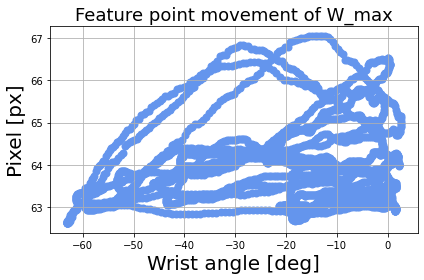

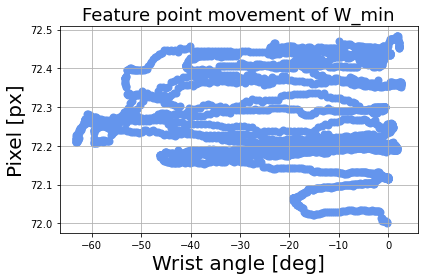

Save completed


In [28]:
### 関節角度-特徴点座標のグラフを作成・保存

point_behavior = analysis_path + "/Results/PointBehavior/" + gonio_file.split(".")[0]

angle = theta.reshape(-1)
# 重みが最大・最小となっている特徴点のみ取り出す
X_max = X[:, W_max_index]
X_min = X[:, W_min_index]

print("angle: ")
print(angle.shape)
print("X_max: ")
print(X_max.shape)
print("X_min: ")
print(X_min.shape)

def Visualize(x, y, save_path, max_or_min):
    fig = plt.figure()
    plt.title("Feature point movement of W_" + max_or_min, fontsize=18)
    plt.xlabel("Wrist angle [deg]", fontsize=20)
    plt.ylabel("Pixel [px]", fontsize=20)
    plt.scatter(x, y, color="cornflowerblue", linewidth=2, label="Feature Point Movement")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    fig.savefig(save_path + max_or_min + ".png")
    plt.close()

Visualize(angle, X_max, point_behavior, "max")
Visualize(angle, X_min, point_behavior, "min")

print("Save completed")

In [29]:
### 関節角度の推定値を導出

theta_pred = np.dot(X, W)

print("theta_pred: ")
print(theta_pred, theta_pred.shape)

theta_pred: 
[[-2.90202956]
 [-2.26060771]
 [ 0.18181086]
 ...
 [21.16416181]
 [21.24451486]
 [20.12140618]] (3212, 1)


x: 
[0.00000000e+00 1.37028963e-02 2.74057926e-02 ... 4.39725942e+01
 4.39862971e+01 4.40000000e+01] (3212,)
y1: 
[-0.23395351 -0.3104139  -0.3935583  ...  2.20259288  2.20666913
  2.21000063] (3212,)
y2: 
[-2.90202956 -2.26060771  0.18181086 ... 21.16416181 21.24451486
 20.12140618] (3212,)


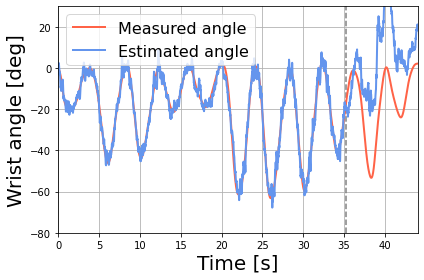

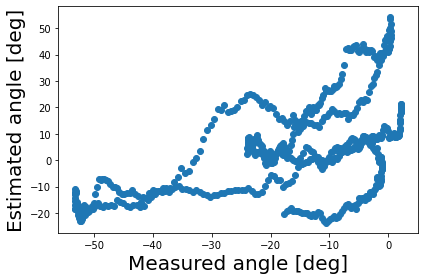

In [30]:
### グラフ作成・保存

angle_estimation = analysis_path + "/Results/AngleEstimation/" + gonio_file.split(".")[0]

x = time
y1 = theta.reshape(-1) # (3212,)
y2 = theta_pred.reshape(-1) # (3212,)

print("x: ")
print(x, x.shape)
print("y1: ")
print(y1, y1.shape)
print("y2: ")
print(y2, y2.shape)

fig1 = plt.figure()
# plt.title("A result of estimating wrist joint angle", fontsize=18)
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Wrist angle [deg]", fontsize=20)
plt.plot(x, y1, color="tomato", linewidth=2, label="Measured angle")
plt.plot(x, y2, color="cornflowerblue", linewidth=2, label="Estimated angle")
line_position = devide_num / echo_frame_rate
plt.vlines(line_position, min_height, max_height, "gray", linestyles="dashed")
plt.ylim(min_height, max_height) #extensor
plt.xlim(0, x.shape[0] / echo_frame_rate)
plt.legend(loc="upper left", fontsize=16)
plt.grid(True)
plt.tight_layout()
fig1.savefig(angle_estimation + "_estimation.png")

fig2 = plt.figure()
# plt.title("Scatter plots of estimated and measured angle", fontsize=16)
plt.xlabel("Measured angle [deg]", fontsize=20)
plt.ylabel("Estimated angle [deg]", fontsize=20)
plt.scatter(y1[devide_num:], y2[devide_num:])
plt.tight_layout()
fig2.savefig(angle_estimation + "_scatter.png")

plt.show()
plt.close()

In [31]:
### RMSE，決定係数R2，相関係数coeffを導出


theta_test = theta.reshape(-1)[devide_num:]
theta_pred_test = theta_pred.reshape(-1)[devide_num:]

T = theta_test.shape[0]
L = np.sum((theta_test - theta_pred_test)**2)
RMSE = np.sqrt(L/T)

R2 = r2_score(theta_test, theta_pred_test)

coef = np.corrcoef(theta_test, theta_pred_test)[0][1]

print("theta_test: ")
print(theta_test.shape)
print("theta_pred_test: ")
print(theta_pred_test.shape)
print("T: " + str(T))
print("L: " + str(L))
print("RMSE: " + str(RMSE))
print("決定係数 R2: " + str(R2))
print("相関係数: " + str(coef) + "\n")




theta_test: 
(643,)
theta_pred_test: 
(643,)
T: 643
L: 446131.20078819257
RMSE: 26.340609027943422
決定係数 R2: -1.7572980434598646
相関係数: 0.5623734726324415



In [1]:
### 結果の保存

# データシートへの保存
f = open(datasheet, "r")
datasheet_all = csv.reader(f)
datasheet_list = [e for e in datasheet_all]
f.close()

flag = True
for row in datasheet_list:
    # 同じ条件で一度結果を出していれば，その列の結果の値のみを変更
    if row[0] == date and row[1] == subject and row[2] == str(pattern) and row[3] == additional_info and row[4] == str(trial_num + 1) \
        and row[6] == str(depth) and row[7] == str(gain) and row[8] == focus and row[9] == str(frequency) and row[10] == str(dynamic_range) \
        and row[12] == gonio_file and row[13] == echo_file:
            row[15], row[16], row[17] = RMSE, R2, coef
            flag = False
# 同じ条件のものがなければ，一番下の列に追加
if flag:
    datasheet_list.append([date, subject, pattern, additional_info, trial_num + 1, "", 
                           depth, gain, focus, frequency, dynamic_range, "", 
                           gonio_file, echo_file, "", RMSE, R2, coef])

with open(datasheet, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(datasheet_list)
    f.close()


# 解析ごとの結果用csvへの保存
RMSE_R2_coef = analysis_path + "/Results/RMSE_R2_coef.csv"

f = open(RMSE_R2_coef, "r")
RMSE_R2_coef_all = csv.reader(f)
RMSE_R2_coef_list = [e for e in RMSE_R2_coef_all]
f.close()

flag = True
for row in RMSE_R2_coef_list:
    # 同じ条件で一度結果を出していれば，その列の結果の値のみを変更
    if row[0] == date and row[1] == subject and row[2] == str(pattern) and row[3] == additional_info and row[4] == str(trial_num + 1) \
        and row[6] == str(depth) and row[7] == str(gain) and row[8] == focus and row[9] == str(frequency) and row[10] == str(dynamic_range) \
        and row[12] == gonio_file and row[13] == echo_file:
            row[15], row[16], row[17] = RMSE, R2, coef
            flag = False
# 同じ条件のものがなければ，一番下の列に追加
if flag:
    print(flag)
    RMSE_R2_coef_list.append([date, subject, pattern, additional_info, trial_num + 1, "", 
                           depth, gain, focus, frequency, dynamic_range, "", 
                           gonio_file, echo_file, "", RMSE, R2, coef])

with open(RMSE_R2_coef, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(RMSE_R2_coef_list)
    f.close()

print("Save completed")

NameError: name 'datasheet' is not defined

In [33]:
# 解析終了
import winsound
frequency = 2000
duration = 1000
winsound.Beep(frequency, duration)